In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

E:\ADMIN\anaconda3\envs\tensor2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_excel('Online Retail (1).xlsx',engine='openpyxl' )
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Since we have sufficient data, we will drop all the rows with missing values.

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
#Let's convert the StockCode to string datatype.
df['StockCode'] = df['StockCode'].astype(str)
df['StockCode'].dtype

dtype('O')

In [8]:
#Let's check out the number of unique customers in our dataset.
customers= df['CustomerID'].unique().tolist()
len(customers)

4372

#### Observation:
- There are 4,372 unique customers in our dataset. For each of these customers, we will extract their buying history.
- In other words, we can have 4,372 sequences of purchases.

- It is a good practice to set aside a small part of the dataset for validation purpose. Therefore, I will use data of 90% of the customers to create word2vec embeddings. Let's split the data.

In [9]:
#shuffles the customer id unique
random.shuffle(customers)

# extract 90% of customer ID's
customer_train = [customers[i] for i in range(round(0.9*len(customers)))] #stores 90% of unique customer ie: 4373

# split data into train and validation set
train_set = df[df['CustomerID'].isin(customer_train)] # returns 3934 cust ids 
validation_set= df[~df['CustomerID'].isin(customer_train)] #returns cust ids which are not in 90%

In [10]:
0.9*len(customers)

3934.8

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [11]:
# list to capture purchase history of the customers
purchases_train = [] #stores prodcut code(stock code) and customer id 

# populate the list with the product codes
for i in tqdm(customer_train):   # loop iterates over 90% of data that is 4373 times
    temp = train_set[train_set["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)
    

100%|██████████| 3935/3935 [00:08<00:00, 465.35it/s]


In [12]:
purchases_train

[['20969', '22273', '22149', '22274', '22139', '21609', '85059'],
 ['21622',
  '46000M',
  '22630',
  '22616',
  '22712',
  '22983',
  '22024',
  '22113',
  '84029E',
  '21488',
  '22900',
  '22895',
  '21035',
  '21755',
  '21754',
  '22659',
  '85123A',
  '22900',
  '21485',
  '21623',
  '82482',
  '22630',
  '47580',
  '22111',
  '84992',
  '84991',
  '22834',
  '21289',
  '82494L',
  '21527',
  '21479',
  '22113',
  '84029E',
  '22837',
  '21621',
  '22656',
  '22616',
  '85123A',
  '22659',
  '22630',
  '22900',
  '21485',
  '22111',
  '22113',
  '21622',
  '84801A',
  '22989',
  '22895',
  '22804',
  '22659',
  '22630',
  '22587',
  '22150',
  '21559',
  '21755',
  '21754',
  '82494L',
  '82482',
  '21519',
  '22713',
  '84247G',
  '22023',
  '21506',
  '22030',
  '22994',
  '22998',
  '84279P',
  '84279B',
  '35809A',
  '35810A',
  '21755',
  '21754',
  '22353',
  '21559',
  '22352',
  '22983',
  '21507',
  '21509',
  '22358',
  '21071',
  '21070',
  '21622',
  '22900',
  '22990

In [13]:
df.loc[df['CustomerID']=='17850.0', 'StockCode']

Series([], Name: StockCode, dtype: object)

In [14]:
df[df['CustomerID'] == '17850.0']['StockCode']

Series([], Name: StockCode, dtype: object)

In [15]:
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_set['CustomerID'].unique()):
    temp = validation_set[validation_set["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 679.12it/s]


### Build word2vec Embeddings for Products

In [16]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3632554, 3669760)

In [17]:
# save word2vec model
model.save("word2vec_2.model")

#### observation
- As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [18]:
model.init_sims(replace=True)

In [19]:
print(model)

Word2Vec(vocab=3160, vector_size=100, alpha=0.03)


Our model has a vocabulary of 3,160 unique words and their vectors of size 100 each. Next, we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [20]:
#extract all vectors
X = model.wv[model.wv.key_to_index ]

X.shape

(3160, 100)

### Visualize word2vec Embeddings
It is always quite helpful to visualize the embeddings that you have created. Over here we have 100 dimensional embeddings. We can't even visualize 4 dimensions let alone 100. Therefore, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction.

In [21]:
import umap.umap_ as umap

In [22]:
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)
cluster_embedding

array([[-3.0187018 , 12.336416  ],
       [-2.6678355 ,  8.644032  ],
       [ 2.6877215 , 10.7261095 ],
       ...,
       [-0.49929032, 11.575827  ],
       [-1.0373265 , 10.638886  ],
       [-1.0255462 , 10.586703  ]], dtype=float32)

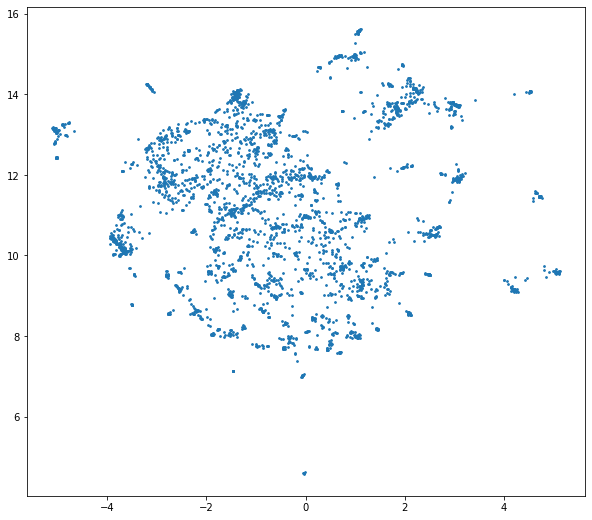

In [23]:
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. As you can see, there are several tiny clusters of these datapoints. These are groups of similar products.

### Start Recommending Products

We are finally ready with the word2vec embeddings for every product in our online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector.

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [24]:
products = train_set[['StockCode', 'Description']]
products.drop_duplicates(inplace=True, subset='StockCode', keep='last')

# create product-ID and product-description dictionary
product_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()
product_dict

{'10002': ['INFLATABLE POLITICAL GLOBE '],
 '10080': ['GROOVY CACTUS INFLATABLE'],
 '10120': ['DOGGY RUBBER'],
 '10123C': ['HEARTS WRAPPING TAPE '],
 '10124A': ['SPOTS ON RED BOOKCOVER TAPE'],
 '10124G': ['ARMY CAMO BOOKCOVER TAPE'],
 '10125': ['MINI FUNKY DESIGN TAPES'],
 '10133': ['COLOURING PENCILS BROWN TUBE'],
 '10135': ['COLOURING PENCILS BROWN TUBE'],
 '11001': ['ASSTD DESIGN RACING CAR PEN'],
 '15030': ['FAN BLACK FRAME '],
 '15034': ['PAPER POCKET TRAVELING FAN '],
 '15036': ['ASSORTED COLOURS SILK FAN'],
 '15039': ['SANDALWOOD FAN'],
 '15044A': ['PINK PAPER PARASOL '],
 '15044B': ['BLUE PAPER PARASOL '],
 '15044C': ['PURPLE PAPER PARASOL'],
 '15044D': ['RED PAPER PARASOL'],
 '15056BL': ['EDWARDIAN PARASOL BLACK'],
 '15056N': ['EDWARDIAN PARASOL NATURAL'],
 '15056P': ['EDWARDIAN PARASOL PINK'],
 '15058A': ['BLUE POLKADOT GARDEN PARASOL'],
 '15058B': ['PINK POLKADOT GARDEN PARASOL'],
 '15058C': ['ICE CREAM DESIGN GARDEN PARASOL'],
 '15060B': ['FAIRY CAKE DESIGN UMBRELLA'],
 '16

In [25]:
product_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

I have defined the function below. It will take a product's vector (n) as input and return top 6 similar products.

In [29]:
def similar_products(v, n=6):
    # extract most similar products for the input vector
    ms = model.wv.similar_by_vector(v, topn=n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (product_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

In [33]:
similar_products(model.wv['90019A'])  #the product code 90019A has most similar products 

[('JADE DROP EARRINGS W FILIGREE', 0.800575852394104),
 ('5 STRAND GLASS NECKLACE CRYSTAL', 0.7923763990402222),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7877522110939026),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7797175645828247),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.7651078701019287),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7585084438323975)]

In [34]:
ms = model.wv.similar_by_vector(model.wv['90019A'])
ms

[('90019A', 0.9999998807907104),
 ('90192', 0.800575852394104),
 ('90199C', 0.7923763990402222),
 ('90016B', 0.7877522110939026),
 ('90018A', 0.7797175645828247),
 ('90036E', 0.7651078701019287),
 ('90177D', 0.7585084438323975),
 ('90014A', 0.7549178600311279),
 ('90123A', 0.754193902015686),
 ('90160D', 0.7532898187637329)]

In [35]:
product_dict['90019A']

['SILVER M.O.P ORBIT BRACELET']

In [36]:
product_dict['90192']

['JADE DROP EARRINGS W FILIGREE']

In [37]:
ms = model.wv.similar_by_vector(model.wv['90192'])
ms

[('90192', 1.0),
 ('90145', 0.8621415495872498),
 ('90016B', 0.8538473844528198),
 ('90177D', 0.8415254354476929),
 ('90185B', 0.8377680778503418),
 ('90082A', 0.8323185443878174),
 ('90162C', 0.8302929997444153),
 ('90036E', 0.8269937038421631),
 ('90018A', 0.8166288137435913),
 ('90209A', 0.813382089138031)]

In [38]:
similar_products(model.wv['90192']) # finds similar products and gives u suggetion in any app like this.

# the prodcut 90192 is about earings and their similar products is shown related to jwellery like earings, pendants and other accesories

[('SILVER HOOP EARRINGS WITH FLOWER', 0.8621415495872498),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.8538473844528198),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.8415254354476929),
 ('AMETHYST DIAMANTE EXPANDABLE RING', 0.8377680778503418),
 ('DIAMANTE BOW BROOCH GREEN COLOUR', 0.8323185443878174),
 ('ANT SILVER FUSCHIA BOUDICCA RING', 0.8302929997444153)]

Cool! The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases he or she has made in the past?

One simple solution is to take average of all the vectors of the products he has bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product ID's and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [39]:
def aggregate_vectors(products):
    product_vec= []
    for i in products:  #product has list of stock code and their description
        try:
            product_vec.append(model.wv[i])
            
        except KeyError:
            continue
            
    return np.mean(product_vec, axis=0)        
            
        

If you can recall, we have already created a separate list of purchase sequences for validation purpose. Now let's make use of that.

In [40]:
len(purchases_val)

437

The length of the first list of products purchased by a user is 437. We will pass this products' sequence of the validation set to the function aggregate_vectors.

In [41]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [42]:
purchases_val[0]

['21258', '21258', '21258', '21258', '21258', '21258']

Well, the function has returned an array of 100 dimension. It means the function is working fine. Now we can use this result to get the most similar products. Let's do it.

In [43]:
similar_products(aggregate_vectors(purchases_val[0]))

[('VICTORIAN SEWING BOX SMALL ', 0.6482700109481812),
 ('VICTORIAN SEWING BOX MEDIUM', 0.6093000769615173),
 ('SHOE SHINE BOX ', 0.4977820813655853),
 ('SET OF 3 COLOURED  FLYING DUCKS', 0.46493595838546753),
 ('GREEN CHRISTMAS TREE STRING 20LIGHT', 0.46438515186309814),
 ('SET OF 3 BABUSHKA STACKING TINS', 0.46160465478897095)]

In [44]:
purchases_val

[['21258', '21258', '21258', '21258', '21258', '21258'],
 ['D',
  '22112',
  '22111',
  '21479',
  '22114',
  '35598B',
  '22866',
  '22865',
  '22632',
  '22684',
  '22676',
  '21481',
  '84032A',
  '21217',
  '22946',
  '22694',
  '82011B',
  '22898',
  '22667',
  '22357',
  '21630',
  '21623',
  '82484',
  '22765',
  '22193',
  '22072',
  '84997A',
  '84997B',
  '21258',
  'D',
  '22357',
  '85048',
  '22625',
  '21363',
  '21361',
  '22193',
  '21257',
  '21242',
  '20676',
  '21238',
  '22469',
  '22694',
  '82484',
  '22470',
  '22794',
  '22795',
  '84029E',
  '22835',
  '21485',
  '22112',
  '21479',
  '21041',
  '21629',
  '22525',
  '22689',
  '21224',
  '71053',
  '22430',
  '71477',
  '22837',
  '22113',
  '22111',
  '22834',
  '22683',
  '22679',
  '22677',
  '22193',
  '22839',
  '35599B',
  '82484',
  '22890',
  '71477',
  '22423',
  '21257',
  '21259',
  '21801',
  '21802',
  '21803',
  '22898',
  '21527',
  '22665',
  '71053',
  '21361',
  '21931',
  '22624',
  '79321'

As it turns out, our system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on the last few purchases only then also you can use the same set of functions.

Below I am giving only the last 10 products purchased as input.

In [47]:
purchases_val[1][-10:]

['23357',
 '23355',
 '21485',
 '84029E',
 '23356',
 '22111',
 '22835',
 '22114',
 '21479',
 '22112']

In [48]:
similar_products(aggregate_vectors(purchases_val[1][-10:]))

[('SCOTTIE DOG HOT WATER BOTTLE', 0.8954473733901978),
 ('HOT WATER BOTTLE TEA AND SYMPATHY', 0.8943198323249817),
 ('HOT WATER BOTTLE I AM SO POORLY', 0.8787105083465576),
 ('RETROSPOT HEART HOT WATER BOTTLE', 0.864169716835022),
 ('HOT WATER BOTTLE KEEP CALM', 0.8399409651756287),
 ('RED WOOLLY HOTTIE WHITE HEART.', 0.8155146837234497)]